# Inception

Utilisation d'un générateur d'images  
Fichiers en local sur le HDD  
Utilisation d'un modèle pré-entrainé inception v3


In [1]:
import tensorflow.compat.v1 as tf 

tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 

print(tf.add([1.0, 2.0], [3.0, 4.0])) 

Executing op Add in device /job:localhost/replica:0/task:0/device:DML:0
tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [10]:
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [1]:
import os

import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt


## Compilation du répertoire principal et du chemin relatif de chaque image


In [2]:
import pathlib
df = pd.read_csv ("allpath.csv")
base_dir = 'D:/champiseed'
df["path"] = base_dir+df["path"] #création du répertoire absolu
df["isweetgum"]=df["identifier_y"].apply(lambda x: "sweetgum.nybg.org" in x) # site ne contenant que des spécimens
df = df[df["isweetgum"]== False] 

Tirage de de 4000 images par "genus" (les classes commentées n'étaient pas disponibles)

In [14]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Paxillus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Clathrus"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Geastrum"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Scleroderma"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Byssomerulius"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Phaeolus"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Agaricus"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Craterellus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10])




# test d'importation sur une image

In [134]:
data['identifier_y'].iloc[45]

'https://mycoportal.org/chrb/mycology/CHRB-F-0012/CHRB-F-0012973_01_lg.jpg'

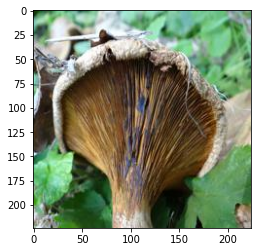

In [5]:
from PIL import Image 
%matplotlib inline
  
# creating a object 
im = Image.open(data["path"].iloc[25]) 
  
plt.imshow(im)

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  
Variante : le validation split est fait à partir de train_datagen
Le générateur ne garde que les images qui sont présentes dans le répertoire

In [32]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

data.head()

from tensorflow.keras.applications.inception_v3.preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# Entrainment depuis des images données dans un dataset
batch_size = 316
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', #"raw", #"'binary', #'sparse' ?
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))

F:\programmes\anaconda\envs\tf plaid\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 11068 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 20932 validated image filenames belonging to 10 classes.
Found 5167 validated image filenames belonging to 10 classes.


F:\programmes\anaconda\envs\tf plaid\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 2833 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


#Création d'un petit script pour nettoyer les images corrompues sinon le modèle s'interrompt à la première erreur de PIL. 
**Etape à généraliser par la suite sur le répertoire principal

In [26]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i) 

In [27]:
tab1 = test_generator.filenames
for i in tab1:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i) 

## Création du modèle inception
En gardant les mêmes compilations que les autres modèles

In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(input_shape=(224,224,3),
                       weights="imagenet",
                       include_top=False
                       )

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


for layer in inception.layers:
    layer.trainable = False

model = Sequential()
model.add(inception)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 10, activation = 'softmax'))
    
model.compile(optimizer = "adam",
             loss = 'sparse_categorical_crossentropy',
             metrics = ["acc"])

## Entrainement

In [33]:
from PIL import Image

incepmodel = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = 10)

Epoch 1/10
66/66 [==============================] - 362s 5s/step - loss: 2.1287 - acc: 0.2413 - val_loss: 2.0665 - val_acc: 0.2830
Epoch 2/10
66/66 [==============================] - 363s 5s/step - loss: 2.1095 - acc: 0.2506 - val_loss: 2.0653 - val_acc: 0.2861
Epoch 3/10
66/66 [==============================] - 363s 5s/step - loss: 2.1001 - acc: 0.2568 - val_loss: 2.0659 - val_acc: 0.2834
Epoch 4/10
66/66 [==============================] - 364s 5s/step - loss: 2.0967 - acc: 0.2602 - val_loss: 2.0571 - val_acc: 0.2924
Epoch 5/10
66/66 [==============================] - 362s 5s/step - loss: 2.0926 - acc: 0.2649 - val_loss: 2.0568 - val_acc: 0.2927
Epoch 6/10
66/66 [==============================] - 365s 6s/step - loss: 2.0939 - acc: 0.2650 - val_loss: 2.0511 - val_acc: 0.2903
Epoch 7/10
66/66 [==============================] - 370s 6s/step - loss: 2.0893 - acc: 0.2679 - val_loss: 2.0421 - val_acc: 0.2956
Epoch 8/10
66/66 [==============================] - 363s 6s/step - loss: 2.0799 - a

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
Très lente évolution, instinctivement, on pourrait penser à modèle non entrainé. Il ne fait pas d'overfitting mais il doit s'entraîner pendant longtemps.

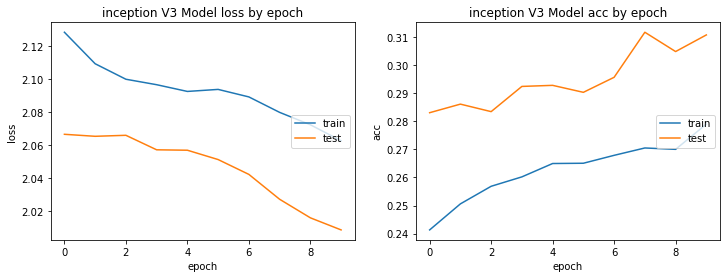

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(incepmodel.history['loss'])
plt.plot(incepmodel.history['val_loss'])
plt.title('inception V3 Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(incepmodel.history['acc'])
plt.plot(incepmodel.history['val_acc'])
plt.title('inception V3 Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 


On affiche les probabilités du champignon testé avec les 7 classes puis le nom de la classe choisie
3 des 4 exemples sont correctement détectés ici mais ce premier modèle reste médiocre (ce qui est normal pour le moment !)


In [37]:
classes = list(train_generator.class_indices.keys())
len(classes)

10

5249 Clathrus


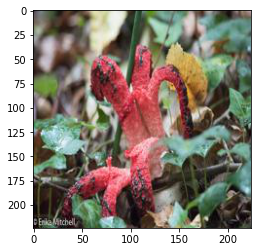

Probabilité pour les 4 classes : [[0.02017499 0.05742724 0.06387335 0.08125496 0.23210698 0.20476672
  0.09464337 0.11350615 0.0648036  0.06744257]]
Classe présentie : Clathrus


In [38]:
#Ces quelques tests montrent effectivement une prédiction hasardeuse, plus mauvaise de le modèle VGG16 de la
#la première itération. (Clathrus semble son "genus" favoris)

from tensorflow.keras.preprocessing import image
import numpy as np

indice = np.random.randint (0,train_generator.samples)

img = image.load_img(data["path"].iloc[indice],target_size=(224,224))
print (indice,data["genus"].iloc[indice])
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

16263 Byssomerulius


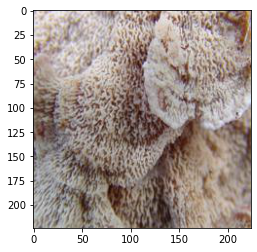

Probabilité pour les 4 classes : [[0.03514789 0.06704255 0.08404637 0.0988374  0.15977283 0.18248136
  0.0587447  0.14197639 0.1023566  0.06959391]]
Classe présentie : Craterellus


In [39]:

from tensorflow.keras.preprocessing import image
import numpy as np

indice = np.random.randint (0,train_generator.samples)

img = image.load_img(data["path"].iloc[indice],target_size=(224,224))
print (indice,data["genus"].iloc[indice])
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

1803 Paxillus


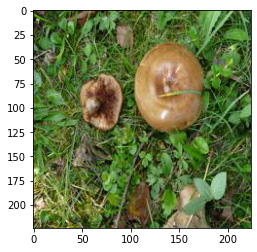

Probabilité pour les 4 classes : [[0.0417232  0.09798609 0.04339616 0.0518658  0.18802918 0.16195434
  0.08635564 0.14885885 0.09149265 0.08833814]]
Classe présentie : Clathrus


In [41]:

from tensorflow.keras.preprocessing import image
import numpy as np

indice = np.random.randint (0,train_generator.samples)

img = image.load_img(data["path"].iloc[indice],target_size=(224,224))
print (indice,data["genus"].iloc[indice])
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

4410 Clathrus


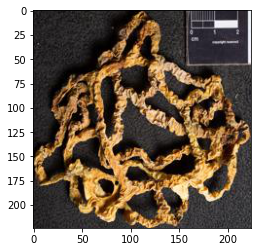

Probabilité pour les 4 classes : [[0.00358034 0.02774937 0.04518431 0.02652864 0.41016987 0.30278385
  0.0586822  0.03471658 0.05257261 0.03803215]]
Classe présentie : Clathrus


In [42]:

from tensorflow.keras.preprocessing import image
import numpy as np

indice = np.random.randint (0,train_generator.samples)

img = image.load_img(data["path"].iloc[indice],target_size=(224,224))
print (indice,data["genus"].iloc[indice])
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

9665 Geastrum


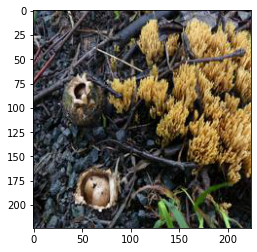

Probabilité pour les 4 classes : [[0.02147378 0.06135768 0.0568256  0.05504331 0.2555401  0.23170327
  0.07480139 0.0873225  0.08933027 0.0666021 ]]
Classe présentie : Clathrus


In [44]:

from tensorflow.keras.preprocessing import image
import numpy as np

indice = np.random.randint (0,train_generator.samples)

img = image.load_img(data["path"].iloc[indice],target_size=(224,224))
print (indice,data["genus"].iloc[indice])
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])